In [1]:
from pathlib import Path
import polars as pl
import duckdb
from datasets import Dataset, concatenate_datasets, load_from_disk
import numpy as np
from autofaiss import build_index
import sys
sys.path.extend(['/home/kevin/PycharmProjects/item_matching'])

from src.item_matching.build_index.func_img import PipelineImage
from src.item_matching.build_index.model import Model
from func import draw_images

## 1) Data 

Prepare 2 datasets: Database and Query

In [2]:
path = Path('/home/kevin/Downloads/cb')
path_db = path / 'cb_2024-03-07.parquet'

# db
query = f"""
select *
,concat('http://f.shopee.vn/file/', UNNEST(array_slice(string_split(images, ','), 1, 1))) image_url
from parquet_scan('{str(path_db)}')
order by item_id, images
"""
df_db = (
    duckdb.sql(query).pl()
    .select(pl.all().name.prefix(f'db_'))
    .head(10_000)
)
pipe = PipelineImage(path, col_image='image_url')
df_img_db = pipe.load_images('db')
df_db = (
    df_db.drop(['images'])
    .join(df_img_db, on='db_image_url', how='left')
    .filter(pl.col('db_exists'))
)


# q
df_q = df_db.clone()
df_q.columns = [f'q_{i.split('db_')[1]}' for i in df_db.columns]
df_q.head()

Loading jpg in folder: 100%|██████████| 862006/862006 [00:00<00:00, 5272682.38it/s]

15:13:25 | INFO | load_images | [Data] Load Images: (862006, 3)


shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ q_item_id ┆ q_item_na ┆ q_shop_id ┆ q_images  ┆ … ┆ q_create_ ┆ q_image_u ┆ q_file_pa ┆ q_exists │
│ ---       ┆ me        ┆ ---       ┆ ---       ┆   ┆ datetime  ┆ rl        ┆ th        ┆ ---      │
│ i64       ┆ ---       ┆ i64       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ bool     │
│           ┆ str       ┆           ┆           ┆   ┆ date      ┆ str       ┆ str       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 299879156 ┆ 🍎FREE    ┆ 619038499 ┆ 020b2fb32 ┆ … ┆ 2022-03-1 ┆ http://f. ┆ /home/kev ┆ true     │
│ 4         ┆ SHIP🍎Lit ┆           ┆ c9e0b6416 ┆   ┆ 6         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ hium067   ┆           ┆ 3acaa30ca ┆   ┆           ┆ /file/020 ┆ ads/cb/do ┆          │
│           ┆ 24Pcs/Bag ┆           ┆ 439c8…    ┆   ┆           ┆ b2fb3…    ┆ wnloa…    ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299943096 ┆ Dụng cụ   ┆ 619035621 ┆ cn-111342 ┆ … ┆ 2022-05-2 ┆ http://f. ┆ /home/kev ┆ true     │
│ 9         ┆ cắt rau   ┆           ┆ 07-7qukw- ┆   ┆ 6         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ củ đa     ┆           ┆ ljmfkrswh ┆   ┆           ┆ /file/cn- ┆ ads/cb/do ┆          │
│           ┆ năng dụng ┆           ┆ 81g72…    ┆   ┆           ┆ 11134…    ┆ wnloa…    ┆          │
│           ┆ …         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299956883 ┆ Bộ 50 Món ┆ 779448044 ┆ sg-111342 ┆ … ┆ 2022-07-2 ┆ http://f. ┆ /home/kev ┆ true     │
│ 3         ┆ Dụng Cụ   ┆           ┆ 01-22090- ┆   ┆ 0         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ Làm Sạch  ┆           ┆ i9hdlm15f ┆   ┆           ┆ /file/sg- ┆ ads/cb/do ┆          │
│           ┆ Răng …    ┆           ┆ xhvd4…    ┆   ┆           ┆ 11134…    ┆ wnloa…    ┆          │
│ 299971434 ┆ [Hàng     ┆ 619019560 ┆ sg-111342 ┆ … ┆ 2022-09-2 ┆ http://f. ┆ /home/kev ┆ true     │
│ 6         ┆ HOT] Giá  ┆           ┆ 01-22100- ┆   ┆ 7         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ đỡ điện   ┆           ┆ jwoiswgbw ┆   ┆           ┆ /file/sg- ┆ ads/cb/do ┆          │
│           ┆ thoại     ┆           ┆ bjv9e…    ┆   ┆           ┆ 11134…    ┆ wnloa…    ┆          │
│           ┆ Gắn…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 299978716 ┆ SUPERCUTE ┆ 881303265 ┆ e0c117e68 ┆ … ┆ 2022-11-1 ┆ http://f. ┆ /home/kev ┆ true     │
│ 5         ┆ Túi Vải   ┆           ┆ b628d42f5 ┆   ┆ 8         ┆ shopee.vn ┆ in/Downlo ┆          │
│           ┆ canvas    ┆           ┆ 28f77da2f ┆   ┆           ┆ /file/e0c ┆ ads/cb/do ┆          │
│           ┆ Đeo Vai…  ┆           ┆ 3d486…    ┆   ┆           ┆ 117e6…    ┆ wnloa…    ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## 2) Embeddings

Use datasets and clip to transform images to vectors

In [3]:
img_model, img_processor = Model().get_img_model(model_id='google/siglip-base-patch16-224')

15:13:25 | INFO | __init__ | [Model] Run on: cuda
15:13:29 | INFO | get_img_model | Image model: google/siglip-base-patch16-224


In [4]:
dataset = Dataset.from_pandas(df_db.to_pandas())
fn_kwargs = {'col': f'db_file_path', 'processor': img_processor, 'model': img_model}
dataset = dataset.map(Model().pp_img, batched=True, batch_size=128, fn_kwargs=fn_kwargs)
dataset.set_format(type='numpy', columns=['img_embed'], output_all_columns=True)

# save to disk
path_tmp_array = Path('tmp/array')
path_tmp_ds = Path('tmp/ds')
np.save(path_tmp_array / 'array.npy', dataset['img_embed'])
dataset.save_to_disk(path_tmp_ds / 'ds')

15:13:29 | INFO | __init__ | [Model] Run on: cuda


Map:   0%|          | 0/10191 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10191 [00:00<?, ? examples/s]

## 3) Indexing

Build index to search items

In [5]:
path_index = Path('tmp/index')
build_index(
    str(path_tmp_array),
    index_path=str(path_index / f'ip.index'),
    index_infos_path=str(path_index / f'index.json'),
    save_on_disk=True,
    metric_type='ip',
    verbose=30,
)

  0%|          | 0/1 [00:00<?, ?it/s]


(<faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x71696989c630> >,
 {'index_key': 'HNSW32',
  'index_param': 'efSearch=17',
  'index_path': 'tmp/index/ip.index',
  'size in bytes': 34076694,
  'avg_search_speed_ms': 2.6742714629672264,
  '99p_search_speed_ms': 15.469311989327252,
  'reconstruction error %': 0.0,
  'nb vectors': 10191,
  'vectors dimension': 768,
  'compression ratio': 0.9187144738864633})

Load index into datasets

In [6]:
dataset_db = concatenate_datasets([
    load_from_disk(str(f)) for f in sorted(path_tmp_ds.glob('*'))
])

# add index
dataset_db.load_faiss_index('img_embed', path_index / f'ip.index')

## 4) Retrieve

Batch search top-k from datasets

In [7]:
score, result = dataset_db.get_nearest_examples_batch(
    'img_embed',
    np.asarray(dataset_db['img_embed']),
    k=5
)

dict_ = {'score_img': [list(i) for i in score]}
df_score = pl.DataFrame(dict_)
df_result = pl.DataFrame(result).drop(['img_embed'])

## 5) Post process

In [8]:
df_match = pl.concat([df_q, df_result, df_score], how='horizontal')
col_explode = [i for i in df_match.columns if 'db' in i] + ['score_img']
df_match = df_match.explode(col_explode)

In [12]:
df_match.to_pandas()

q_item_id                                        q_item_name  \
0       2998791564  🍎FREE SHIP🍎Lithium067 24Pcs/Bag Tattoo Machine...   
1       2998791564  🍎FREE SHIP🍎Lithium067 24Pcs/Bag Tattoo Machine...   
2       2998791564  🍎FREE SHIP🍎Lithium067 24Pcs/Bag Tattoo Machine...   
3       2998791564  🍎FREE SHIP🍎Lithium067 24Pcs/Bag Tattoo Machine...   
4       2998791564  🍎FREE SHIP🍎Lithium067 24Pcs/Bag Tattoo Machine...   
...            ...                                                ...   
50950  14298758417  WHYME Đồ chơi rối tay động vật hoạt hình dễ th...   
50951  14298758417  WHYME Đồ chơi rối tay động vật hoạt hình dễ th...   
50952  14298758417  WHYME Đồ chơi rối tay động vật hoạt hình dễ th...   
50953  14298758417  WHYME Đồ chơi rối tay động vật hoạt hình dễ th...   
50954  14298758417  WHYME Đồ chơi rối tay động vật hoạt hình dễ th...   

       q_shop_id                                           q_images  \
0      619038499  020b2fb32c9e0b64163acaa30ca439c8,2602f3413e362...   
1      619038499  020b2fb32c9e0b64163acaa30ca439c8,2602f3413e362...   
2      619038499  020b2fb32c9e0b64163acaa30ca439c8,2602f3413e362...   
3      619038499  020b2fb32c9e0b64163acaa30ca439c8,2602f3413e362...   
4      619038499  020b2fb32c9e0b64163acaa30ca439c8,2602f3413e362...   
...          ...                                                ...   
50950  946581486  cn-11134211-7qukw-lgknvjm77u6648,sg-11134201-7...   
50951  946581486  cn-11134211-7qukw-lgknvjm77u6648,sg-11134201-7...   
50952  946581486  cn-11134211-7qukw-lgknvjm77u6648,sg-11134201-7...   
50953  946581486  cn-11134211-7qukw-lgknvjm77u6648,sg-11134201-7...   
50954  946581486  cn-11134211-7qukw-lgknvjm77u6648,sg-11134201-7...   

      q_level1_global_be_category q_create_datetime  \
0             Fashion Accessories        2022-03-16   
1             Fashion Accessories        2022-03-16   
2             Fashion Accessories        2022-03-16   
3             Fashion Accessories        2022-03-16   
4             Fashion Accessories        2022-03-16   
...                           ...               ...   
50950                  Mom & Baby        2023-05-06   
50951                  Mom & Baby        2023-05-06   
50952                  Mom & Baby        2023-05-06   
50953                  Mom & Baby        2023-05-06   
50954                  Mom & Baby        2023-05-06   

                                             q_image_url  \
0      http://f.shopee.vn/file/020b2fb32c9e0b64163aca...   
1      http://f.shopee.vn/file/020b2fb32c9e0b64163aca...   
2      http://f.shopee.vn/file/020b2fb32c9e0b64163aca...   
3      http://f.shopee.vn/file/020b2fb32c9e0b64163aca...   
4      http://f.shopee.vn/file/020b2fb32c9e0b64163aca...   
...                                                  ...   
50950  http://f.shopee.vn/file/cn-11134211-7qukw-lgkn...   
50951  http://f.shopee.vn/file/cn-11134211-7qukw-lgkn...   
50952  http://f.shopee.vn/file/cn-11134211-7qukw-lgkn...   
50953  http://f.shopee.vn/file/cn-11134211-7qukw-lgkn...   
50954  http://f.shopee.vn/file/cn-11134211-7qukw-lgkn...   

                                             q_file_path  q_exists  \
0      /home/kevin/Downloads/cb/download_img/img_db/0...      True   
1      /home/kevin/Downloads/cb/download_img/img_db/0...      True   
2      /home/kevin/Downloads/cb/download_img/img_db/0...      True   
3      /home/kevin/Downloads/cb/download_img/img_db/0...      True   
4      /home/kevin/Downloads/cb/download_img/img_db/0...      True   
...                                                  ...       ...   
50950  /home/kevin/Downloads/cb/download_img/img_db/0...      True   
50951  /home/kevin/Downloads/cb/download_img/img_db/0...      True   
50952  /home/kevin/Downloads/cb/download_img/img_db/0...      True   
50953  /home/kevin/Downloads/cb/download_img/img_db/0...      True   
50954  /home/kevin/Downloads/cb/download_img/img_db/0...      True   

        db_item_id                                      

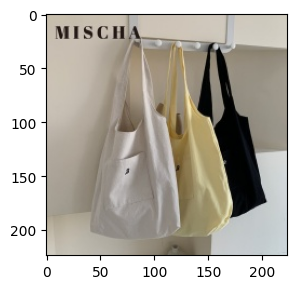

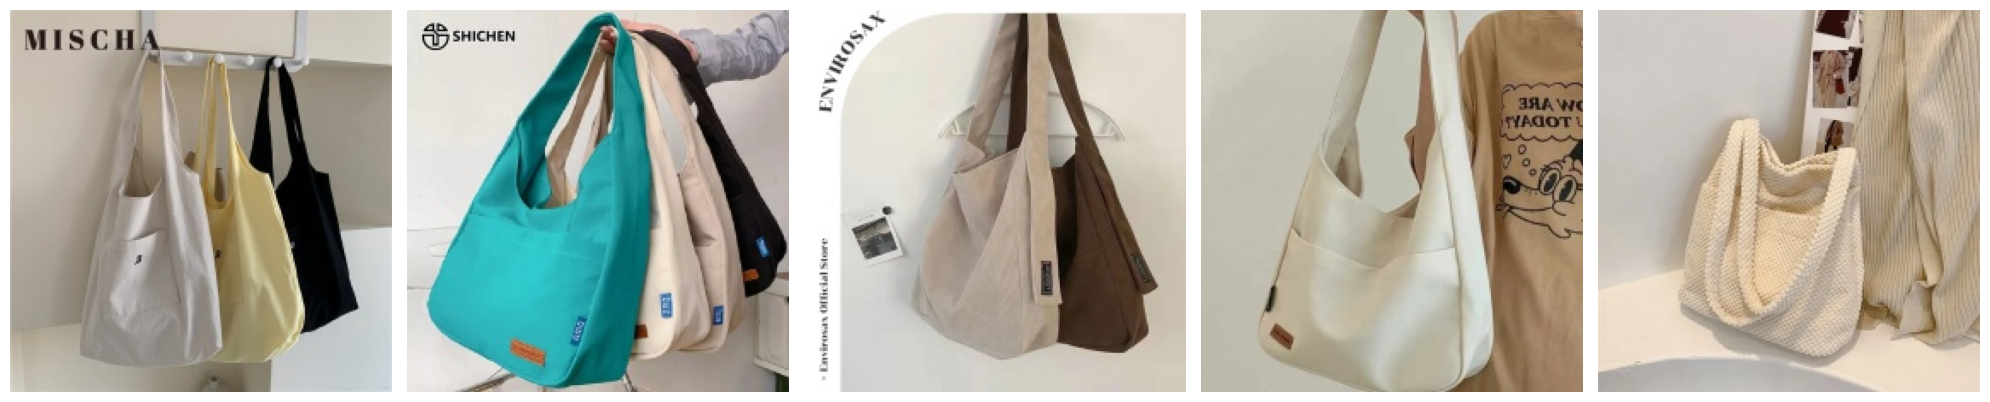

In [17]:
draw_images(df_match, 2999787165)

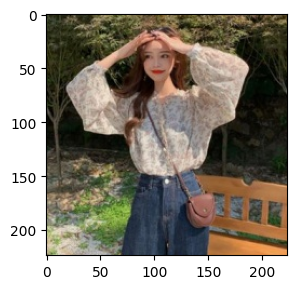

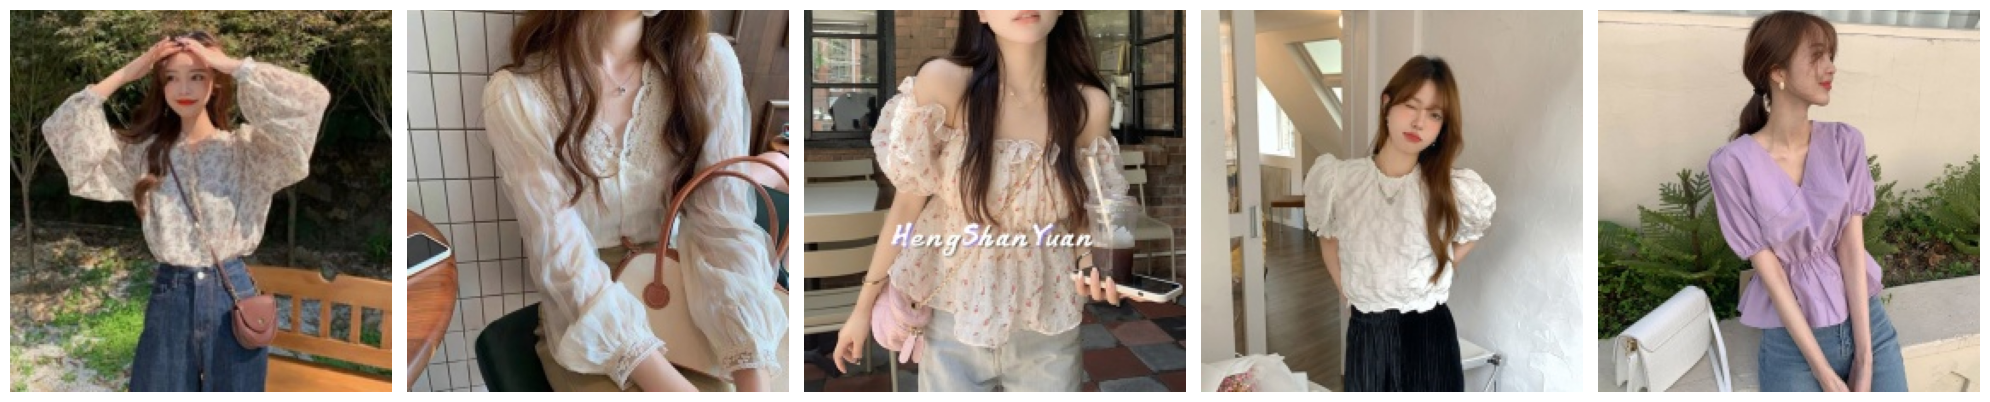

In [16]:
draw_images(df_match, 3099789245)

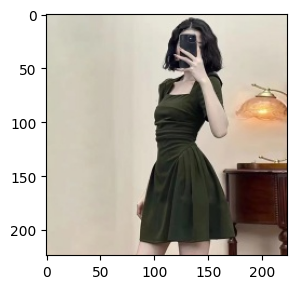

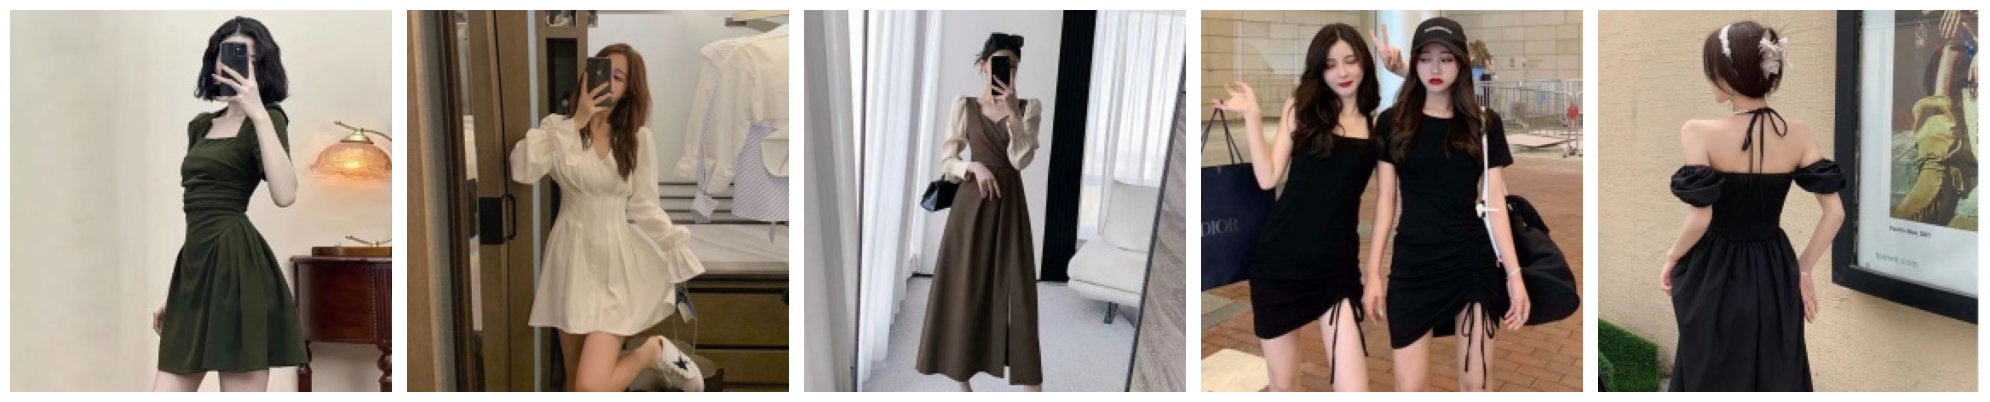

In [14]:
draw_images(df_match, 2999838844)

IndexError: index 5 is out of bounds for axis 0 with size 5

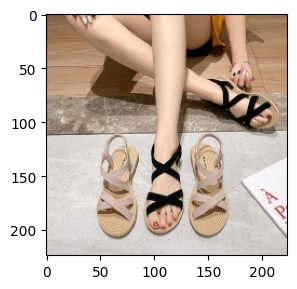

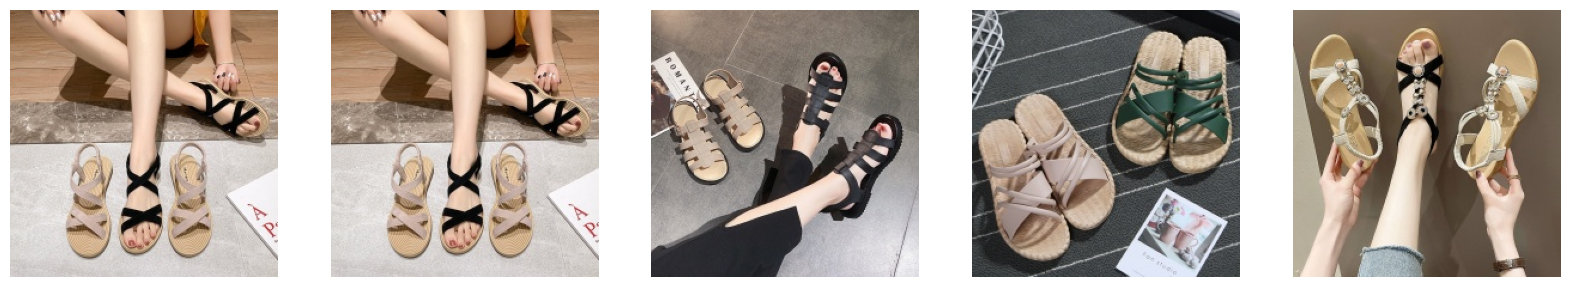

In [15]:
draw_images(df_match, 3099458499)

In [11]:
# df_match.write_csv(path / 'match.csv')